# Step by step preprocessing

Fist, we need to import the packages. We will need nilearn (learning algorithms and image manipulation), pandas and numpy (data structures manipulation).

In [49]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import nilearn

from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img

from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel

from nilearn.plotting import plot_design_matrix

# Let us use a Nifti file that is shipped with nilearn
from nilearn.datasets import MNI152_FILE_PATH

## Let's look at the raw data (i.e. data as acquired)

To start, we need to inform the software where are the data.


In [37]:
# Set variables
ROOT_DATA='/Users/home/Documents/BIDS/'
ROOT_DATA='/home/brunomiguel/Documents/data/BIDS/'
SUB='sub-0002'
SES='ses-001'
RUN='run-01'

# data folder
data_path=os.path.join(ROOT_DATA, SUB, SES)
print('The data is in this folder - ' + data_path)

# project folder
ROOT_PROJECT="/Users/home/Documents/GitHub/MVPA-speech_project"



The data is in this folder - /home/brunomiguel/Documents/data/BIDS/sub-0002/ses-001


# Structural data.

## Raw data.

Let's look at the raw data.

/home/brunomiguel/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


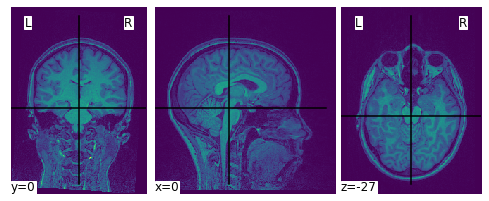

In [23]:
t1w_fp=os.path.join(data_path, 'anat', 
                           SUB + '_' + SES + '_run-01_T1w.nii.gz')
plotting.plot_img(t1w_fp)

First we used the FSL toolbox to preprocess the structural image. 

https://www.youtube.com/watch?v=VobRXk3ccNQ

BET - Brain extraction.
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide

(used default values - with Fractional intensity threshold of 0.5)

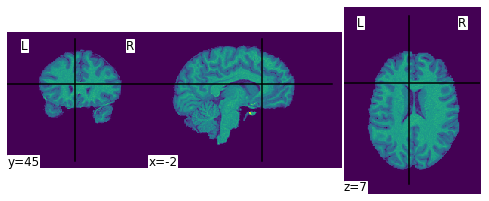

In [24]:
t1w_brain_fp=os.path.join(data_path, 'anat', SUB + '_' + SES + '_run-01_T1w.anat',
                                 'T1_biascorr_brain.nii.gz')

plotting.plot_img(t1w_brain_fp)

## Functional data preprocessing

Raw functional data.


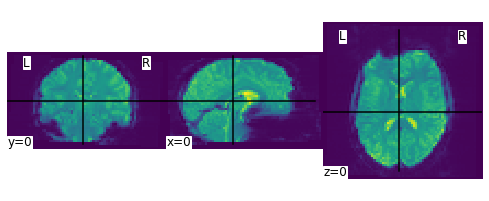

In [25]:
func_data_pp=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + 
                          '_task-nomeacaoinner_'+ RUN +'_bold.nii.gz')

# Mean image  to check motion correction.
m_img=mean_img(func_data_pp)
                          
# coordinates to place cross in mean image.
cut_coords=(0, 0, 0)

# Plot mean functional image.
plotting.plot_img(m_img, cut_coords)

Second step includes the FEAT - fMRI Expert Analysis Tool https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FEAT.

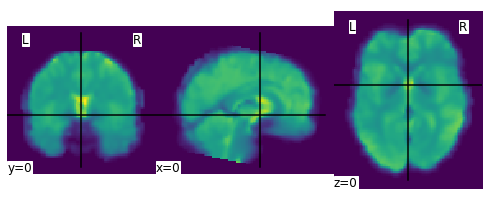

In [59]:
func_data_pp=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + '_task-nomeacaoinner_run-01_bold_pp_standard.nii.gz')

# Mean image  to check motion correction.
m_img=mean_img(func_data_pp)
                          
# coordinates to place cross in mean image.
cut_coords=(0, 0, 0)

# Plot mean functional image.
plotting.plot_img(m_img, cut_coords)

We see the data smoothed and registered to MNI standard.

How many images do we have in this dataset?

In [60]:
func_d_img=image.load_img(func_data_pp)

n_imgs=func_d_img.shape[3]
print('this dataset has ' + str(n_imgs) + ' images.')

this dataset has 125 images.


## Design matrix.

Let us look at the events over time.

In [96]:
# repetition time - acquisition parameter.
tr=3  

# here are the correspoding onset times.
frame_times = np.arange(n_imgs) * tr  

# load events.tsv
events_fn=func_data_pp=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + 
                          '_task-nomeacaoinner_'+ RUN + '_events.tsv')

events_df=pd.read_csv(events_fn, sep='\t', na_values="n/a")
print(events_df.head(10))
print(events_df.shape)

   trial_type  onset  duration
0           0      0         3
1           0      3         3
2           0      6         3
3           0      9         3
4           0     12         3
5          25     15         3
6          14     18         3
7           1     21         3
8           2     24         3
9          31     27         3
(125, 3)


Everything looks fine! shape

<AxesSubplot:label='conditions', ylabel='scan number'>

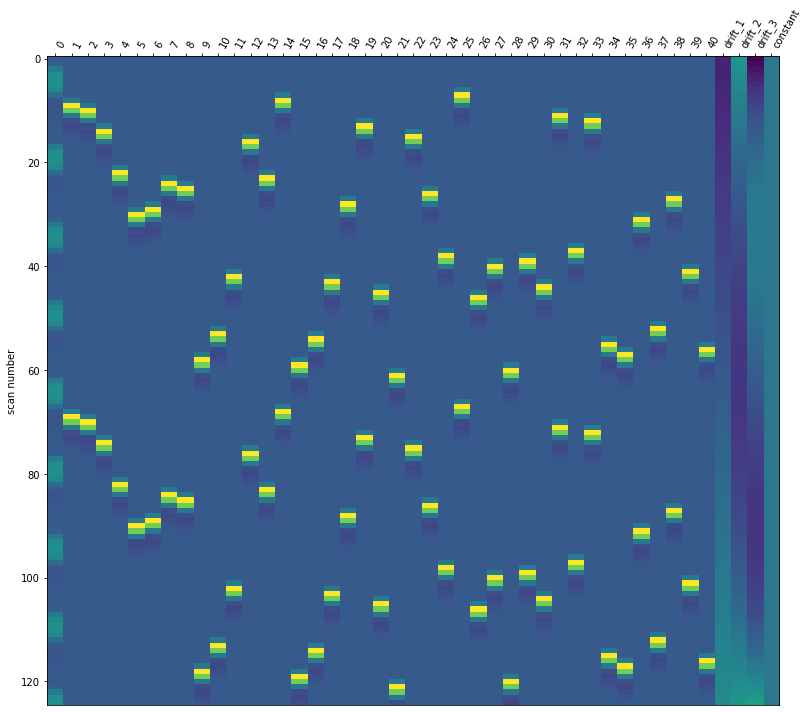

In [97]:
# Define the HRF function.
hrf_model='spm'

# Set the corresponding design matrix.
design_matrix = make_first_level_design_matrix(events_df['onset'], events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

plot_design_matrix(design_matrix)

Now we need to create the **beta series** - one *different* event per TR.

In [98]:
events_bs=events_df.copy()

# Create new events series.
event_bs=events_bs.drop(events_bs.tail(5).index, inplace=True)
print(events_df.shape)
print(events_bs.shape)

(125, 3)
(120, 3)


In [99]:
print(events_bs)

     trial_type  onset  duration
0             0      0         3
1             0      3         3
2             0      6         3
3             0      9         3
4             0     12         3
..          ...    ...       ...
115          35    345         3
116           9    348         3
117          15    351         3
118          28    354         3
119          21    357         3

[120 rows x 3 columns]


<AxesSubplot:label='conditions', ylabel='scan number'>

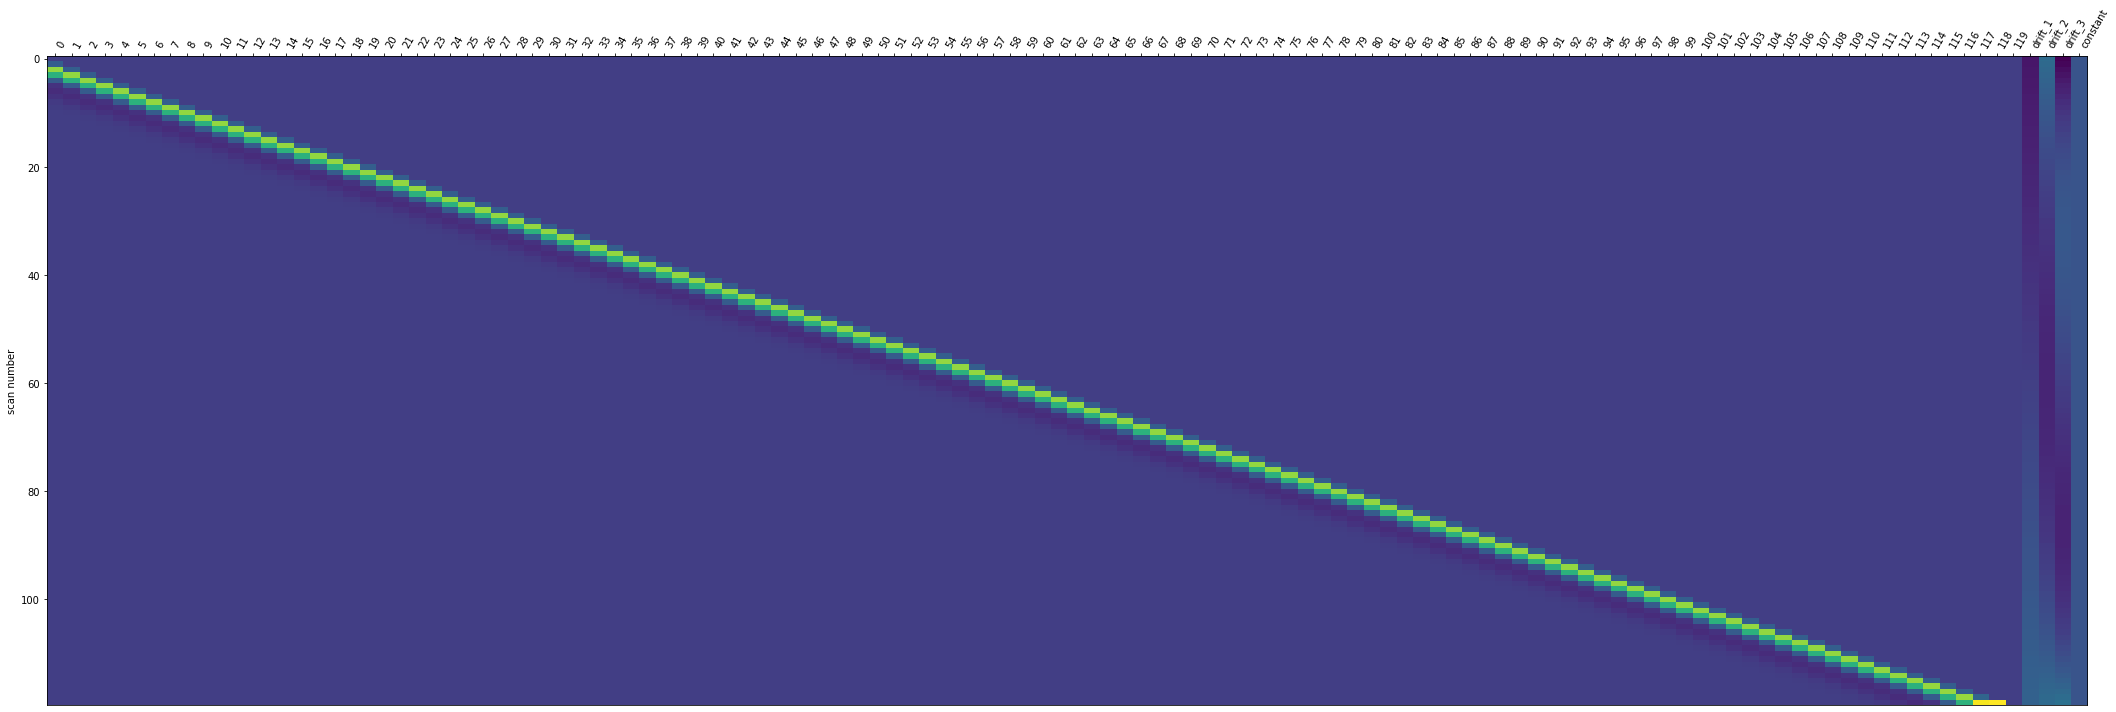

In [100]:
events_bs['trial_type']=range(120)

# Set the design matrix relative to the beta series.
d_mat_betaseries = make_first_level_design_matrix(events_bs['onset'], events_bs,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

plot_design_matrix(d_mat_betaseries)

In [111]:
d_mat_betaseries

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,drift_1,drift_2,drift_3,constant
onset,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.500000,0.165266,-0.048747,1.0
3,0.098025,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.491597,0.156933,-0.043831,1.0
6,0.564368,0.098025,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.483193,0.148742,-0.039124,1.0
9,0.394139,0.564368,0.098025,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.474790,0.140692,-0.034621,1.0
12,0.088186,0.394139,0.564368,0.098025,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.466387,0.132783,-0.030320,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.098025,0.000000,0.000000,0.000000,0.000000,0.0,0.466387,0.132783,0.030320,1.0
348,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.564368,0.098025,0.000000,0.000000,0.000000,0.0,0.474790,0.140692,0.034621,1.0
351,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.394139,0.564368,0.098025,0.000000,0.000000,0.0,0.483193,0.148742,0.039124,1.0


In [116]:
# Define contrasts for all predictors.
contrast_mat = np.eye(d_mat_betaseries.shape[0], d_mat_betaseries.shape[1]-5)
print(d_mat_betaseries.shape)
print(contrast_mat.shape)

all_cntrsts = dict([(column, contrast_mat[i])
                        for i, column in enumerate(d_mat_betaseries.columns)])

# Fit GLM models for all contrasts/predictors
print('Fitting a GLM')
fmri_glm = FirstLevelModel()
fmri_glm.fit(func_d_img, design_matrices=d_mat_betaseries)

z_maps=[]

for contrast in all_cntrsts:
    z_maps.append(fmri_glm.compute_contrast(all_cntrsts[contrast], output_type='z_score'))

(120, 124)
(120, 119)


IndexError: index 120 is out of bounds for axis 0 with size 120

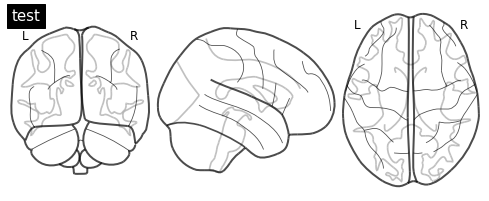

In [69]:
# plot the contrasts 
# the display is overlayed on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
plotting.plot_glass_brain(
    z_maps[10], threshold=2.0, title='test')
plotting.show()